In [1]:
import pathlib
import random
from functools import reduce
from collections import defaultdict

import pandas as pd
import geopandas as gpd
import folium
import shapely
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sklearn.cluster
import tensorflow as tf

from geoband import API

from h3 import h3
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from statistics import mean


plt.rcParams["font.family"] = 'NanumGothic'
pd.set_option('display.max_columns', None)

In [2]:
# DATA PATH 설정
input_path = pathlib.Path('./input')
if not input_path.is_dir():
    input_path.mkdir()

API.GetCompasData('SBJ_2007_001', '1', input_path.joinpath('운영이력.csv'))
API.GetCompasData('SBJ_2007_001', '2', input_path.joinpath('자전거스테이션.csv'))
API.GetCompasData('SBJ_2007_001', '10', input_path.joinpath('도시계획(공간시설).geojson'))
API.GetCompasData('SBJ_2007_001', '11', input_path.joinpath('도시계획(공공문화체육시설).geojson'))
API.GetCompasData('SBJ_2007_001', '12', input_path.joinpath('도시계획(교통시설).geojson'))
API.GetCompasData('SBJ_2007_001', '17', input_path.joinpath('일반건물_분포도(100M_X_100M).geojson'))
API.GetCompasData('SBJ_2007_001', '6', input_path.joinpath('인구(거주)_분포도(100M_X_100M).geojson'))
API.GetCompasData('SBJ_2007_001', '19', input_path.joinpath('전철역_공간정보.csv'))
API.GetCompasData('SBJ_2007_001', '28', input_path.joinpath('코드정의서.xlsx'))
API.GetCompasData('SBJ_2007_001', '16', input_path.joinpath('도로명주소_도로.geojson'))
API.GetCompasData('SBJ_2007_001', '15', input_path.joinpath('도로명주소_건물.geojson'))

API.GetCompasData('SBJ_2007_001', '20', input_path.joinpath('고양시 버스정류소.csv'))
API.GetCompasData('SBJ_2007_001', '21', input_path.joinpath('버스 정류장별 승하차 정보.csv'))
API.GetCompasData('SBJ_2007_001', '22', input_path.joinpath('주차장정보.csv'))
API.GetCompasData('SBJ_2007_001', '29', input_path.joinpath('지하철 역별 이용객수.csv'))

for path in list(input_path.glob('*.csv')) + list(input_path.glob('*.geojson')):
    print(path)

input/운영이력.csv
input/자전거스테이션.csv
input/전철역_공간정보.csv
input/고양시 버스정류소.csv
input/버스 정류장별 승하차 정보.csv
input/주차장정보.csv
input/지하철 역별 이용객수.csv
input/꽃박람회일정.csv
input/KINTEX행사일정.csv
input/기상정보.csv
input/인구통계.csv
input/도시계획(공간시설).geojson
input/도시계획(공공문화체육시설).geojson
input/도시계획(교통시설).geojson
input/일반건물_분포도(100M_X_100M).geojson
input/인구(거주)_분포도(100M_X_100M).geojson
input/도로명주소_도로.geojson
input/도로명주소_건물.geojson
input/인구(거주)분포도(100M_X_100M).geojson


In [3]:
# 데이터 로드
운영이력 = pd.read_csv(input_path.joinpath('운영이력.csv'))
자전거스테이션 = pd.read_csv(input_path.joinpath('자전거스테이션.csv'))
버스정류소 =pd.read_csv(input_path.joinpath('고양시 버스정류소.csv'))
버스이용고객 =pd.read_csv(input_path.joinpath('버스 정류장별 승하차 정보.csv'))
주차장 =pd.read_csv(input_path.joinpath('주차장정보.csv'))
전철역 = pd.read_csv(input_path.joinpath('전철역_공간정보.csv'))
역별이용객수 = pd.read_csv(input_path.joinpath('지하철 역별 이용객수.csv'))

공간시설 = gpd.read_file(input_path.joinpath('도시계획(공간시설).geojson'))
문화체육시설 = gpd.read_file(input_path.joinpath('도시계획(공공문화체육시설).geojson'))
교통시설 = gpd.read_file(input_path.joinpath('도시계획(교통시설).geojson'))
건물분포도 = gpd.read_file(input_path.joinpath('일반건물_분포도(100M_X_100M).geojson'))
인구분포도 = gpd.read_file(input_path.joinpath('인구(거주)_분포도(100M_X_100M).geojson'))
도로명주소_건물=gpd.read_file(input_path.joinpath('도로명주소_건물.geojson'))
도로명주소_도로=gpd.read_file(input_path.joinpath('도로명주소_도로.geojson'))

코드정의서= pd.read_excel(input_path.joinpath('코드정의서.xlsx'))

/opt/app-root/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. 데이터 전처리

주요 전처리 사항
1. 새로 만든 칼럼 : 
    * '공원' (반경 내 공원의 개수)
2. 병합한 칼럼 :
    * 버스정류소, 버스이용고객
    * 전철역, 역별이용객수
    * 건물코드, 건물유형이름

In [4]:
# 1-1. 자전거 스테이션 전처리 : Station_ID의 데이터타입을 string으로 변환
for column in ['Station_ID']:
    자전거스테이션[column] = 자전거스테이션[column].apply(str)
for column in ['Station_ID']:
    자전거스테이션[column] = 자전거스테이션[column].apply(str)

In [5]:
# 1-2. 도시계획(공간시설) 전처리
# 1-2-1. 잘못된 데이터 drop
공간시설 = 공간시설[공간시설['REMARK'] != '?？??렐由곌났？']
공간시설 = 공간시설[공간시설['ALIAS'] != '2011.08.26'].reset_index()
#1-2-2. '공원' 칼럼 생성
공간시설['공원'] = 공간시설['REMARK'].apply(lambda x : 0 if x == None else 1)
#1-2-3. '주차장' 여부 칼럼 생성
주차장['여부'] = 1

In [6]:
#1-3. 버스 정류소, 버스이용고객 전처리 : ID 기준 병합
버스정류소 = pd.merge(버스정류소,버스이용고객,on='STATION_ID')

In [7]:
#1-4. 전철역, 역별이용객수 전처리 : station_nm 기준 merge

#1-4-1. '역명' 통일
for i in 역별이용객수.index:
    if 역별이용객수['역명'][i] == '지축':
        역별이용객수['역명'][i] = '지축역'
    if 역별이용객수['역명'][i] == '화전':
        역별이용객수['역명'][i] = '화전(한국항공대)'
역별이용객수 = 역별이용객수.merge(전철역,left_on='역명',right_on='station_nm')

for i in 역별이용객수.index:
    for j in 전철역.index:
        if 역별이용객수['역명'][i] == 전철역['station_nm'][j]:
            역별이용객수['X'][i] = 전철역['X'][j]
            역별이용객수['Y'][i] = 전철역['Y'][j]
            
뉴역별 = pd.DataFrame()
뉴역별['역명'] = 역별이용객수['역명']
뉴역별['X'] = 역별이용객수['X']
뉴역별['Y'] = 역별이용객수['Y']
뉴역별['모든요일_합계'] = 역별이용객수['모든요일_합계']

tmp_list_승차 = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60]
tmp_list_하차 = [i+1 for i in tmp_list_승차]
tmp_list_승하차 = [i+2 for i in tmp_list_승차]

뉴역별_승차 = 뉴역별.loc[tmp_list_승차,:]
뉴역별_승차 = 뉴역별_승차.reset_index()

뉴역별_하차 = 뉴역별.loc[tmp_list_하차,:]
뉴역별_하차 = 뉴역별_하차.reset_index()

뉴역별_승하차 = 뉴역별.loc[tmp_list_승하차,:]
뉴역별_승하차 = 뉴역별_승하차.reset_index()

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A v

In [8]:
#1-5. 도로명주소_건물 전처리

#1-5-1. 코드 정의서 : 도로명주소의 건물 코드로 유형 이름 merge
코드정의서=코드정의서[64:537].rename({'Unnamed: 0':'BDTYP_CD','Unnamed: 1':'BDTYP_NM'},axis='columns')
도로명주소_건물 = 도로명주소_건물.merge(코드정의서,on='BDTYP_CD',how='left')
도로명주소_건물['여부'] = 1

#1-5-2. 도로명주소 건물 사전 생성 : 건물 유형을 key, 유형별 개수를 value로 갖는 사전
도로명주소_건물_사전 = defaultdict(int)

for i in 도로명주소_건물['BDTYP_NM'].unique():
    도로명주소_건물_사전[i]
for i in 도로명주소_건물.index:
    도로명주소_건물_사전[도로명주소_건물.loc[i,'BDTYP_NM']] += 1
도로명주소_건물_사전=list(도로명주소_건물_사전)

In [9]:
#1-6. 일반건물분포도 : 연면적 0초과인 것들만 필터링
건물분포도 = 건물분포도[건물분포도['val']>0]
#1-7. 인구(거주)분포도 : 인구분포 0초과인 것들만 필터링
인구분포도 = 인구분포도[인구분포도['val']>0]

# 2. 그리드 데이터 생성

1. 임의로 후보 위경도 생성
2. h3 라이브러리를 이용한 육각형 그리드 생성
3. 점수 환산을 위한 기존 스테이션 위경도 concat

In [10]:
#2-1. 임의로 후보 위경도 생성 : 인구분포도의 위경도 이용
후보위경도_0 = pd.DataFrame({'lng':인구분포도['geometry'].centroid.x,'lat':인구분포도['geometry'].centroid.y})

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [11]:
def counts_by_hexagon(df, resolution):
    df = df[["lat","lng"]]# df에서 lat, lng만 가져와 처리
    
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["lat"], row["lng"], resolution), axis = 1) 
    # 행단위로 lambda에 넣은 위경도 -> h3 좌표로 바꾸는 함수를 apply하고, 그 결과를 'hex_id'라는 칼럼으로 정의.
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index() # hex_id를 기준으로 groupby를 size로
    df_aggreg.columns = ["hex_id", "value"] # 칼럼이름을 각각 hex_id와 value로 변경
    
    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: h3.h3_to_geo_boundary(x,geo_json=True))
    # -> geometry칼럼을 생성해 거기에 육각형의 점 각각에 대한 좌표를 저장. -> 일단 필요 x
    return df_aggreg

def 중심좌표(geometry):
    sumx = 0
    sumy = 0
    for i in range(len(geometry)):
        pt = geometry[i]
        
        sumx += pt[0]
        sumy += pt[1]

        
    return [sumx/len(geometry),sumy/len(geometry)]

In [12]:
#2-2. h3 라이브러리를 이용한 육각형 그리드 생성, 중심좌표 구하기 
후보그리드_0 = counts_by_hexagon(후보위경도_0,9) #resolution 값 : 9 (2-4 블록 사이즈)
후보그리드_0.value=1
후보그리드_0['lng'] = 후보그리드_0['geometry'].apply(lambda x : 중심좌표(x)[0])
후보그리드_0['lat'] = 후보그리드_0['geometry'].apply(lambda x : 중심좌표(x)[1])
후보그리드 = 후보그리드_0.drop('geometry',axis=1)

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
#자전거스테이션의 위경도 데이터 concat : 학습데이터에 포함시키기 위해
자전거스테이션 = 자전거스테이션.rename(columns={'Station_ID':'hex_id','거치대 수량':'value','위도':'lat','경도':'lng'},)
후보그리드 = pd.concat([후보그리드,자전거스테이션]).reset_index().drop('index',axis=1) #인덱스 1803까지 후보 그리드, 이후부터 자전거스테이션

# 3. 학습데이터
그리드 데이터 기반 변수 통합

* '인구분포', '공원', '건물연면적합','버스정류소_탑승인구합','전철역_승차인구합','전철역_하차인구합','건물총개수','건물유형'
* 건물 유형 분류 : 건물 유형을 대분류로 병합

In [14]:
#3-1. 거리 설정 : 그리드의 중심에서 꼭지점까지의 반경
x1 = 후보그리드_0.loc[0,'geometry'][0][1]
y1 = 후보그리드_0.loc[0,'geometry'][0][0]

x2 = 후보그리드_0.loc[0,'lat']
y2 = 후보그리드_0.loc[0,'lng']

거리 = math.sqrt(((x1-x2)**2)+(y1-y2)**2)

In [15]:
def make_데이터(경도, 위도):
    batch_size = 32
    
    #데이터의 중심점 경위도를 array로
    공간시설_경위도 = np.stack([공간시설['geometry'].centroid.x, 공간시설['geometry'].centroid.y],axis =1).reshape([1, -1, 2])
    문화체육시설_CD = 문화체육시설['DGM_NM'].unique().tolist()
    문화체육시설_경위도 = np.stack([문화체육시설['geometry'].centroid.x, 문화체육시설['geometry'].centroid.y],axis =1).reshape([1, -1, 2])
    문화체육시설_속성 = 문화체육시설.loc[:,'DGM_NM'].apply(문화체육시설_CD.index).values.reshape([1,-1])
    건물연면적_경위도 = np.stack([건물분포도['geometry'].centroid.x,건물분포도['geometry'].centroid.y],axis=1).reshape([1,-1,2])
    인구분포도_경위도 = np.stack([인구분포도['geometry'].centroid.x,인구분포도['geometry'].centroid.y],axis=1).reshape([1,-1,2])
    도로명주소_건물_NM = 도로명주소_건물['BDTYP_NM'].unique().tolist()
    도로명주소_건물_경위도 = np.stack([도로명주소_건물['geometry'].centroid.x, 도로명주소_건물['geometry'].centroid.y],axis =1).reshape([1, -1, 2])
    도로명주소_건물_속성 = 도로명주소_건물.loc[:,'BDTYP_NM'].apply(도로명주소_건물_NM.index).values.reshape([1,-1])
    
    
    버스정류소_경위도 = np.stack([버스정류소['X'], 버스정류소['Y']], axis=1)
    주차장_경위도 = np.stack([주차장['X'], 주차장['Y']], axis=1)
    전철역_승차_경위도 = np.stack([뉴역별_승차['X'], 뉴역별_승차['Y']], axis=1)
    전철역_하차_경위도 = np.stack([뉴역별_하차['X'], 뉴역별_하차['Y']], axis=1)    
    주차장_경위도 = np.stack([주차장['X'], 주차장['Y']], axis=1)
    
    
    데이터 = pd.DataFrame()
    for i in tqdm(range(int(np.ceil(len(경도) / batch_size)))):
        s, e = batch_size * i, batch_size * (i + 1)
        자전거스테이션_경위도 = np.stack([경도[s:e], 위도[s:e]], axis=1).reshape([-1, 1, 2])
        
        #데이터 만들 조건
        공간시설_조건 = np.sum((자전거스테이션_경위도 - 공간시설_경위도)**2, axis=2) ** 0.5 < 거리 
        공원여부 = np.array([공간시설.loc[x,'공원'].sum() for x in 공간시설_조건])
        
        도로명주소_건물_조건 = np.sum((자전거스테이션_경위도 - 도로명주소_건물_경위도)**2, axis=2)**0.5 < 거리
        건물총개수 = np.array([도로명주소_건물.loc[x,'여부'].sum() for x in 도로명주소_건물_조건])
    
        dict={}
        list=[]
        for j in 도로명주소_건물_사전:
            도로명주소_건물1=도로명주소_건물[도로명주소_건물['BDTYP_NM']==j]
            도로명주소_건물1_경위도 = np.stack([도로명주소_건물1['geometry'].centroid.x, 도로명주소_건물1['geometry'].centroid.y],axis =1).reshape([1, -1, 2])
            도로명주소_건물1_조건 = np.sum((자전거스테이션_경위도 - 도로명주소_건물1_경위도)**2, axis=2)**0.5 < 거리
            list.append(np.array([도로명주소_건물1.loc[x,'여부'].sum() for x in 도로명주소_건물1_조건]))
        
                       
        버스정류소_조건 = np.sum((자전거스테이션_경위도 - 버스정류소_경위도)**2, axis=2)**0.5 < 거리
        버스정류소_탑승인구합 = np.array([버스정류소.loc[x,'GETON_CNT'].sum() for x in 버스정류소_조건])
        
        전철역_승차_조건 = np.sum((자전거스테이션_경위도 - 전철역_승차_경위도)**2, axis=2)**0.5 < 거리
        전철역_승차인구합 = np.array([뉴역별_승차.loc[x,'모든요일_합계'].sum() for x in 전철역_승차_조건])
        전철역_하차_조건 = np.sum((자전거스테이션_경위도 - 전철역_하차_경위도)**2, axis=2)**0.5 < 거리
        전철역_하차인구합 = np.array([뉴역별_하차.loc[x,'모든요일_합계'].sum() for x in 전철역_하차_조건])
        
        주차장_조건 = np.sum((자전거스테이션_경위도 - 주차장_경위도)**2, axis=2)**0.5 < 거리
        주차장개수 = np.array([주차장.loc[x,'여부'].sum() for x in 주차장_조건])
        #baseline

        건물연면적_조건 = np.sum((자전거스테이션_경위도 - 건물연면적_경위도)**2, axis=2) ** 0.5 < 거리
        건물연면적합 = np.array([건물분포도.loc[x,'val'].sum() for x in 건물연면적_조건])
        인구분포_조건 = np.sum((자전거스테이션_경위도 - 인구분포도_경위도)**2, axis=2) ** 0.5 < 거리
        인구분포 =  np.array([인구분포도.loc[x,'val'].sum() for x in 인구분포_조건])
        
        데이터 = 데이터.append(pd.DataFrame(
            columns=['인구분포','공원', '건물연면적합','건물총개수','버스정류소_탑승인구합','전철역_승차인구합','전철역_하차인구합','주차장']+도로명주소_건물_사전, #+도로명주소_건물_사전'인구분포', '전철역', '버스정류소', *BDTYP_CD],
            data=np.stack([인구분포,공원여부,건물연면적합,건물총개수,버스정류소_탑승인구합, 전철역_승차인구합, 전철역_하차인구합, 주차장개수]+list, axis=1), #+dict.values() , 전철역_조건, 버스정류소_조건, *도로명주소_건물_데이터], axis=1),
        ), ignore_index=True)
        
    return 데이터

In [16]:
# 약 20분 소요
클러스터_학습데이터 = make_데이터(후보그리드['lng'], 후보그리드['lat'])
클러스터_학습데이터

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-proje

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



,인구분포,공원,건물연면적합,건물총개수,버스정류소_탑승인구합,전철역_승차인구합,전철역_하차인구합,주차장,다가구주택,다세대주택,기타제1종근린생활시설,의원,단독주택,운동장,NaN,소매점,무도장,일반음식점,소방서,제조업소,학원,서점(1종근.생미해당),기타제2종근생활시설,위험물제조소,수리점,연립주택,다중주택,사무소,부동산중개업소,기타공장,연수원,체육도장,기타종교집회장,단란주점,기타종교시설,마을회관,기타운동시설,극장,고시원,아파트,기타사무소,기타문화및집회시설,유흥주점,기타공공시설,체력단련장,마을공동시설,휴게음식점,물류터미널,기타공연장,액화가스취급소,기타운수시설,공관,하역장,투전기업소,기타동.식물원,공중화장실,자동차영업소,기타의료시설,기숙사,영유아보육시설,공항시설,독서실,노인복지시설,기타전시장,교회,기타판매시설,동물병원,방송국,생활편익시설,복리시설,부대시설,한의원,금융업소,중학교,변전소,기타교육원,유원시설업의시설,기타위락시설,기타학교,정수장,기타위험물저장처리시설,연예장,기타동식물관련시설,쇼핑센터,농수산물공판장,기원,체육장,대형점,파출소,우체국,공공시설,기타창고시설,폐차장,집배송시설,기타아동관련시설,표구점,종교집회장,교육원,테니스장,동물원,노래연습장,사찰,양수장,당구장,마을공동작업소,음악당,세탁소,마을공동구판장,기타자동차관련시설,작물재배사,영화관,여객자동차터미널,비디오물소극장,경찰서,비디오물감상실,기타집회장,기념관,단란주점,대피소,서어커스장,보건소,기타소매시장,침술원,성당,위험물저장소,치과의원,경마장,액화가스판매소,골프연습장,시장,백화점,기타숙박시설,출판사,주점영업,탁구장,접골원,조산원,사진관,체육관,과학관,세차장,공공도서관,기타관광휴게시설,식물원
0,0.0,0.0,0.00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,72.0,0.0,491.56,58.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,28.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,93.0,0.0,863.49,66.0,217.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,26.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,288.0,0.0,1055.93,136.0,958.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,72.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,210.0,0.0,1218.26,84.0,236.0,0.0,0.0,0.0,2.0,16.0,1.0,0.0,34.0,0.0,0.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [17]:
def 건축물_통합(df):
    #단독주택
    df['비공동주택'] = df['단독주택']+df['다중주택']+df['다가구주택']+df['공관']
    
    #공동주택
    df['공동주택'] = df['아파트']+df['연립주택']+df['다세대주택']+df['생활편익시설']+df['부대시설']+df['복리시설']+df['기숙사']
    
    #제1종근린생활시설
    df['제1종근린'] = df['마을공동구판장']+df['마을공동작업소']+df['조산원']+df['소매점']+df['휴게음식점']+df['의원']+df['침술원']+df['체육장']+df['탁구장']+df['접골원']+df['마을공동시설']+df['변전소']+df['양수장']+df['정수장']+df['대피소']+df['공중화장실']+df['세탁소']+df['한의원']+df['체육도장']+df['마을회관']+df['기타제1종근린생활시설']
    #제1종근린생활시설-공공시설
    df['제1종근린_공공시설'] = df['보건소']+df['경찰서']+df['파출소']+df['소방서']+df['우체국']+df['방송국']+df['기타공공시설']+df['공공시설']+df['공공도서관']
    
    #제2종근린생활시설
    df['제2종근린'] = df['서점(1종근.생미해당)']+df['독서실']+df['기원']+df['노래연습장']+df['일반음식점']+df['휴게음식점']+df['제조업소']+df['수리점']+df['사진관']+df['표구점']+df['학원']+df['동물병원']+df['자동차영업소']+df['세탁소']+df['고시원']
    #제2종근린생활시설-운동시설
    df['제2종근린_운동시설'] = df['체력단련장']+df['골프연습장']+df['기타운동시설']+df['당구장']+df['테니스장']
    #제2종근린생활시설-공연장
    df['제2종근린_공연장'] = df['음악당']+df['연예장']+df['극장']+df['영화관']+df['기타공연장']
    #제2종근린생활시설-사무소
    df['제2종근린_사무소'] = df['금융업소']+df['사무소']+df['부동산중개업소']+df['기타사무소']+df['기타제2종근생활시설']+df['출판사']
    
    #문화및집회시설
    df['문화집회'] = df['기타문화및집회시설']+df['운동장']+df['기타전시장']
    #문화및집회시설_공연장
    df['문화집회_공연장'] = df['서어커스장']+df['비디오물감상실']+df['비디오물소극장']
    #문화및집회시설-동식물원
    df['문화집회_동식물원'] = df['동물원']+df['식물원']+df['기타동.식물원 ']+df['작물재배사']+df['기타동식물관련시설']
    #문화및집회시설-전시장
    df['문화집회_전시장'] = df['과학관']+df['기념관']
    #문화및집회시설-관람장
    df['문화집회_관람장'] = df['체육관']+df['경마장']
    #문화및집회시설_집회장
    df['문화집회_집회장'] = df['기타집회장']
    
    #종교시설
    df['종교시설'] = df['교회']+df['성당']+df['사찰']+df['기타종교집회장']+df['기타종교시설']+df['종교집회장']
    
    #판매시설
    df['판매시설'] = df['쇼핑센터']+df['소매점']+df['기타판매시설']+df['백화점']+df['시장']+df['기타소매시장']+df['대형점']+df['농수산물공판장']
    
    #운수시설
    df['운수시설'] = df['여객자동차터미널']+df['공항시설']+df['기타운수시설']
    
    #의료시설
    df['의료시설'] = df['기타의료시설']+df['의원']+df['한의원']+df['치과의원']
    
    #창고시설
    df['창고시설'] = df['물류터미널']+df['집배송시설']+df['기타창고시설']+df['하역장']
    
    #교육연구시설 (공공도서관)
    df['교육연구시설'] = df['학원']+df['중학교']+df['기타학교']+df['교육원']+df['연수원 ']+df['사무소']+df['기타교육원']
    
    #노유자시설
    df['노유자시설'] = df['영유아보육시설']+df['기타아동관련시설']+df['노인복지시설']
    
    #위험물저장및처리시설
    df['위험물저장및처리시설'] = df['위험물제조소']+df['위험물저장소']+df['액화가스취급소']+df['기타위험물저장처리시설']+df['액화가스판매소']
    
    #공장
    df['유해공장'] = df['기타공장']
    
    #위락시설
    df['위락시설'] = df['단란주점']+df['단란주점 ']+df['유흥주점']+df['기타위락시설']+df['투전기업소']+df['무도장']+df['유원시설업의시설']+df['주점영업']
    
    #관광휴게시설
    df['관광휴게시설'] = df['공원']+df['기타관광휴게시설']
    
    #숙박시설
    df['숙박시설'] = df['기타숙박시설']

    #자동차관련시설
    df['자동차관련시설'] = df['주차장']+df['기타자동차관련시설']+df['세차장']+df['폐차장']
    
    df = df.drop(['다가구주택', '다세대주택','단독주택', '연립주택', '다중주택','고시원', '아파트','기숙사'], axis=1)
    df = df.drop(['기타제1종근린생활시설','기타제2종근생활시설','작물재배사'], axis=1)
    df = df.drop(['독서실','의원', '기타의료시설','동물병원','한의원','치과의원'], axis=1)
    df = df.drop(['마을공동구판장','마을공동작업소','기타동.식물원 ','운동장', '체육도장', '기타운동시설', '극장','기타문화및집회시설', '체력단련장','기타공연장','기타전시장','연예장', '체육장', '동물원', '음악당','영화관','골프연습장', '기타숙박시설'], axis=1)
    df = df.drop(['소매점', '일반음식점','수리점','사무소','부동산중개업소', '기타사무소','휴게음식점', '자동차영업소','기타판매시설','금융업소','표구점', '세탁소','사진관'], axis=1)
    df = df.drop(['소방서', '기타공공시설','공중화장실', '영유아보육시설', '공항시설','방송국','생활편익시설','복리시설', '부대시설','정수장', '파출소', '우체국','공공시설','기타아동관련시설','여객자동차터미널','경찰서', '대피소'], axis=1)
    df = df.drop(['제조업소', '기타공장','위험물제조소','액화가스취급소', '변전소','기타위험물저장처리시설', '양수장', '위험물저장소'], axis=1)
    df = df.drop(['노래연습장','학원','중학교', '기타교육원','기타학교','교육원','연수원 '],axis=1)
    df = df.drop(['기타종교집회장','기타종교시설', '교회', '사찰', '성당','보건소'], axis=1)
    df = df.drop(['테니스장','단란주점 ','유흥주점', '투전기업소', '기타위락시설','주점영업','당구장'], axis=1)
    df = df.drop(['마을회관','마을공동시설','단란주점','기념관','기타집회장','비디오물감상실','비디오물소극장'], axis=1)
    df = df.drop(['물류터미널','기타운수시설','기타창고시설', '집배송시설', '기타자동차관련시설','서점(1종근.생미해당)'], axis=1)
    df = df.drop(['침술원','탁구장','무도장','접골원','하역장','유원시설업의시설','식물원','공원','기타관광휴게시설'], axis=1)
    df = df.drop(['백화점','조산원','공관','종교집회장','폐차장','대형점','기원','농수산물공판장','쇼핑센터','기타동식물관련시설','노인복지시설'], axis=1)
    df = df.drop(['주차장','공공도서관','세차장','과학관','체육관','출판사','시장','액화가스판매소','경마장','기타소매시장','서어커스장'], axis=1)
    
    return df

In [18]:
학습데이터 = 건축물_통합(클러스터_학습데이터)

In [19]:
학습데이터.to_csv('./학습데이터.csv',index=False,encoding='utf-8-sig')

In [20]:
학습데이터 = pd.read_csv('./학습데이터.csv',encoding='utf-8-sig')

In [21]:
학습데이터.drop(columns = ['Unnamed: 6'])

,인구분포,건물연면적합,건물총개수,버스정류소_탑승인구합,전철역_승차인구합,전철역_하차인구합,비공동주택,공동주택,제1종근린,제1종근린_공공시설,제2종근린,제2종근린_운동시설,제2종근린_공연장,제2종근린_사무소,문화집회,문화집회_공연장,문화집회_동식물원,문화집회_전시장,문화집회_관람장,문화집회_집회장,종교시설,판매시설,운수시설,의료시설,창고시설,교육연구시설,노유자시설,위험물저장및처리시설,유해공장,위락시설,관광휴게시설,숙박시설,자동차관련시설
0,0.0,0.00,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,72.0,491.56,58.0,0.0,0.0,0.0,28.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,93.0,863.49,66.0,217.0,0.0,0.0,26.0,8.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,288.0,1055.93,136.0,958.0,0.0,0.0,72.0,8.0,15.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,210.0,1218.26,84.0,236.0,0.0,0.0,36.0,16.0,13.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,2296.0,79197.57,12.0,15586.0,0.0,0.0,0.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1964,1587.0,31635.55,17.0,13995.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1965,1612.0,87112.67,8.0,14821.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1966,3347.0,98056.66,8.0,3263.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4.클러스터링

In [22]:
#4-1. StandardScaler()로 데이터 정규화
standard_scaler = StandardScaler()
fitted = standard_scaler.fit(학습데이터)
output = fitted.transform(학습데이터)

클러스터데이터 = pd.DataFrame(output,columns=학습데이터.columns, index=list(학습데이터.index.values))

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


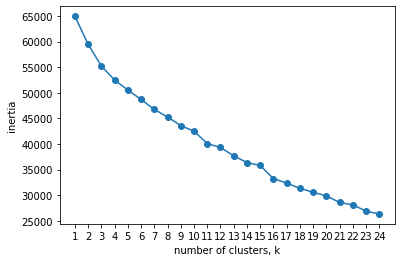

In [23]:
#4-2. 적정 클러스터 개수 구하기 : 기울기가 완만해지면서, 클러스터의 개수를 최소화할 수 있는 n_cluster 10으로 결정
ks = range(1,25)
inertias = []


for k in ks:
    model = KMeans(n_clusters=k,init='k-means++')
    model.fit(클러스터데이터)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [24]:
#4-3.비지도 학습 : Kmeans algorithm
num_clusters = 10
kmeans_clustering = KMeans( n_clusters = num_clusters, init='random',random_state=0 )
idx = kmeans_clustering.fit_predict(클러스터데이터)
클러스터데이터['분류'] = idx

In [25]:
#4-4. 클러스터별 특징 파악
#4-4-1. 클러스터별 변수 값 파악
클러스터 = 클러스터데이터.groupby(by='분류').mean()
클러스터['개수'] = 클러스터데이터.groupby(by='분류').count()['Unnamed: 6']
클러스터

,인구분포,건물연면적합,건물총개수,버스정류소_탑승인구합,전철역_승차인구합,전철역_하차인구합,Unnamed: 6,비공동주택,공동주택,제1종근린,제1종근린_공공시설,제2종근린,제2종근린_운동시설,제2종근린_공연장,제2종근린_사무소,문화집회,문화집회_공연장,문화집회_동식물원,문화집회_전시장,문화집회_관람장,문화집회_집회장,종교시설,판매시설,운수시설,의료시설,창고시설,교육연구시설,노유자시설,위험물저장및처리시설,유해공장,위락시설,관광휴게시설,숙박시설,자동차관련시설,개수
분류,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.264951,-0.199158,-0.001151,-0.044509,-0.122258,-0.121380,0.0,-0.099967,-0.152874,0.171044,-0.138999,0.354607,5.217298,-0.130657,0.076496,-0.039561,-0.036835,0.063231,-0.031895,-0.031895,-0.031895,0.070197,0.311378,0.027212,0.091793,0.059140,0.252688,-0.084942,0.215243,-0.021230,0.176921,0.528118,-0.022547,-0.172614,60
1,-0.583065,-0.414072,0.913866,-0.207573,-0.122258,-0.121380,0.0,0.040703,-0.309389,0.869314,-0.232616,1.628926,-0.169122,-0.051878,0.595997,4.369180,-0.036835,-0.060220,-0.031895,1.198879,-0.031895,0.100891,0.726547,-0.135299,-0.121390,1.747514,0.241967,-0.084942,-0.104419,0.267869,0.052533,-0.102547,0.847520,-0.172614,51
2,0.699666,1.142523,0.498480,0.312069,-0.122258,-0.121380,0.0,0.192907,0.393944,0.497431,1.437315,0.452674,-0.038753,-0.130657,1.580094,-0.028338,-0.036835,-0.060220,-0.031895,-0.031895,-0.031895,0.683666,0.039608,0.021469,0.355501,-0.110029,1.930066,2.174046,-0.030366,-0.194146,2.087267,-0.102547,-0.022547,5.148310,37
3,-0.512869,-0.357922,-0.436888,-0.181209,-0.102954,-0.102221,0.0,-0.279382,-0.383645,-0.373788,-0.194256,-0.316834,-0.169122,-0.130657,-0.297176,-0.137797,-0.036835,0.004818,0.029343,-0.031895,0.029343,-0.191340,-0.330543,-0.162911,-0.121710,-0.057215,-0.289821,-0.075348,0.026564,0.120468,-0.186475,-0.028713,-0.022547,-0.146251,1025
4,-0.434137,-0.373440,0.865558,-0.135449,-0.122258,-0.121380,0.0,0.159207,-0.060936,1.927106,-0.039369,1.292795,-0.169122,-0.130657,1.183441,0.144244,-0.036835,-0.026243,-0.031895,-0.031895,-0.031895,0.226378,1.979102,-0.021530,0.181308,0.122773,0.680852,-0.039835,0.084110,-0.055018,0.527709,0.013171,-0.022547,-0.172614,218
5,0.325794,1.379990,0.049579,5.641093,6.978297,6.942301,0.0,-0.095907,-0.128648,-0.089547,2.295053,0.247256,-0.008334,0.003266,0.483730,-0.018799,-0.036835,-0.060220,-0.031895,-0.031895,-0.031895,0.526773,-0.158400,0.749764,0.816615,-0.110029,1.332166,1.390045,-0.104419,-0.234912,0.627571,-0.102547,-0.022547,1.242821,30
6,-0.194220,-0.126317,-0.166493,-0.127579,-0.122258,-0.121380,0.0,-0.114035,-0.066582,-0.167214,-0.036673,-0.089276,-0.169122,5.382000,-0.182603,-0.160266,-0.036835,-0.060220,-0.031895,-0.031895,-0.031895,0.088399,-0.089468,-0.185303,0.124209,-0.110029,-0.101705,-0.084942,-0.104419,-0.006907,-0.031878,0.190786,-0.022547,-0.082840,43
7,0.499953,0.360235,0.193386,0.210199,-0.122258,-0.121380,0.0,0.053379,0.295607,0.128316,0.415504,0.273681,-0.169122,0.023870,0.299516,-0.223219,-0.036835,-0.060220,-0.031895,-0.031895,-0.031895,2.011899,-0.214326,6.092072,0.585015,-0.110029,0.633363,0.482361,-0.104419,-0.176899,-0.113736,-0.102547,-0.022547,0.569747,26
8,1.685031,1.294591,-0.385697,0.152725,-0.106671,-0.106530,0.0,-0.432197,1.014856,-0.455226,0.172216,-0.386791,-0.169122,-0.130657,-0.337529,-0.220989,-0.036835,0.028754,-0.031895,-0.031895,-0.031895,-0.021471,-0.439038,-0.001506,-0.076479,-0.110029,-0.050304,-0.070177,-0.096191,-0.225853,-0.167548,0.030025,-0.022547,-0.103060,333


# 5. 클러스터별 점수 환산

In [26]:
#5-1. 데이터 전처리
#5-1-1. 클러스터데이터 : 후보 클러스터, 스테이션 클러스터 분리 / 위경도 데이터와 concat
스테이션_클러스터 = pd.merge(클러스터데이터.iloc[1804:],후보그리드.iloc[1804:],left_index=True,right_index=True,how='left').reset_index()
후보_클러스터 = pd.merge(클러스터데이터.iloc[:1804],후보그리드.iloc[:1804],left_index=True,right_index=True,how='left')

#5-1-2. 운영이력 : RTN_STATION이 0인 이상치 처리
예외값=운영이력[운영이력['RTN_STATION']==0].index
운영이력_수정=운영이력.drop(예외값)

In [27]:
#5-2. 대여,반납 스테이션ID를 클러스터링 분류값으로 매핑
df_stations=[]
for i in range(0,num_clusters):
    name= '스테이션_'+str(i)
    name=스테이션_클러스터[스테이션_클러스터['분류']==i]
    df_stations.append(name)
    
for i in range(0,num_clusters):
    운영이력_수정.loc[운영이력_수정['LEAS_STATION'].isin(df_stations[i].index.tolist()), 'LEAS_CLUSTER'] = i
    운영이력_수정.loc[운영이력_수정['RTN_STATION'].isin(df_stations[i].index.tolist()), 'RTN_CLUSTER'] = i                               

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


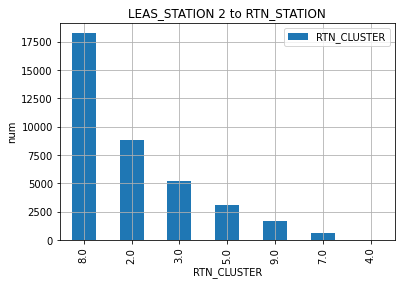

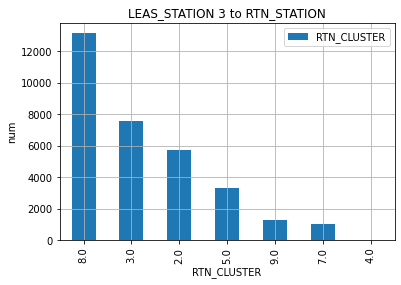

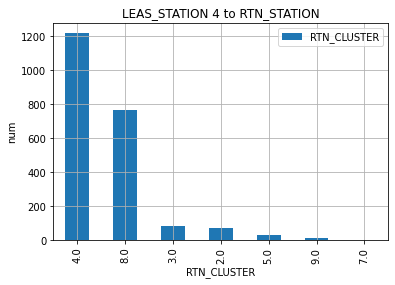

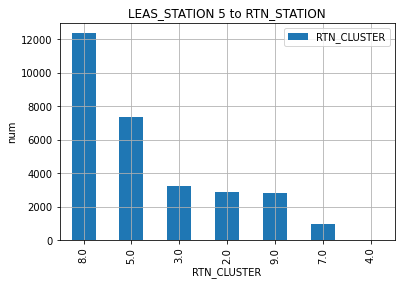

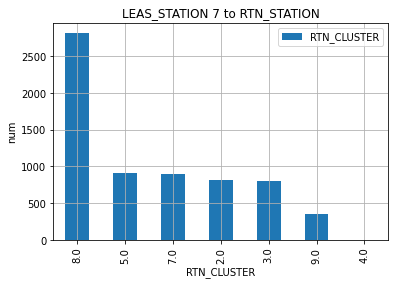

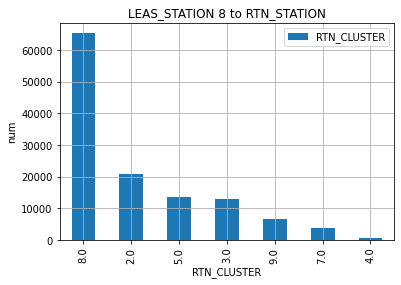

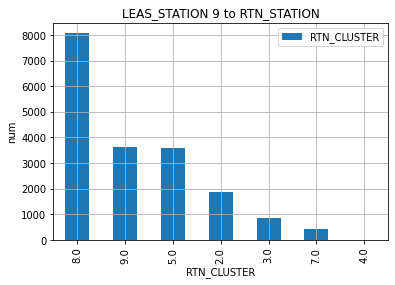

In [28]:
#5-3. 대여-반납 스테이션 유형별 link 시각화

for i in range(0,num_clusters):
    if len(운영이력_수정[운영이력_수정['LEAS_CLUSTER']==i])!=0:
        운영이력_수정[운영이력_수정['LEAS_CLUSTER']==i]['RTN_CLUSTER'].value_counts().plot.bar()
        plt.grid()
        plt.legend()
        plt.title('LEAS_STATION '+str(i)+' to RTN_STATION')
        plt.xlabel("RTN_CLUSTER")
        plt.ylabel("num")   
        plt.show()

In [29]:
#5-4. 점수환산표
score=pd.DataFrame(columns=['LEAS_CLUSTER','RTN_CLUSTER','SCORE'],index=range(0,100))
lst=[i for i in range(0,10)]
score['LEAS_CLUSTER']= sorted(lst*10)
score['RTN_CLUSTER']=lst*10

for i in score.index:
    lea_num=score['LEAS_CLUSTER'][i]
    rtn_num=score['RTN_CLUSTER'][i]
    df=운영이력_수정[운영이력_수정['LEAS_CLUSTER']==lea_num]          
    if len(df)==0:          #특정 분류에 속하지 않는 스테이션이 있으면 0점처리
        score['SCORE'][i]=0
    else :
        score['SCORE'][i]=round((len(df[df['RTN_CLUSTER']==rtn_num])/len(score))*100,2)
score

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/app-root/lib/python3.6/sit

,LEAS_CLUSTER,RTN_CLUSTER,SCORE
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
95,9,5,3595
96,9,6,0
97,9,7,447
98,9,8,8076


# 6. 각 그리드에 점수 부여
후보 그리드와 인근 N~M m 사이에 있는 그리드에 점수표 기반 점수 부여

1. 평균 및 min, max 이용 거리 알아보기
2. 지정한 반경 안에 위치한 그리드에 점수표 기반으로 점수 부여하기

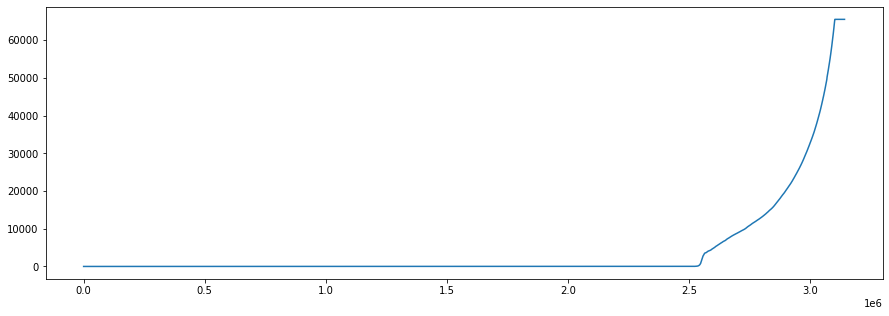

In [30]:
#6-1. 운영이력 평균 거리 구하기
plt.figure(figsize=(15,5))
plt.plot(운영이력['TRNV_QTY'].fillna(0).sort_values().reset_index().drop(['index'],axis=1))

#하지만 결측치가 너무 많고, 데이터의 단위에 오류가 있는 것으로 판단해 서울 공공자전거의 평균 이용거리를 참고하여 임의의 거리를 지정하였음.

In [31]:
#6-2. 최빈 클러스터 삭제
후보_클러스터 =후보_클러스터[후보_클러스터['분류'] != 후보_클러스터['분류'].mode()[0]]

In [32]:
#6-3. 후보 그리드 점수 부여
#6-3-1. 거리 계산 함수
def calc_distance(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    km = 6371 * c
    m = km * 100
    return m

In [33]:
#6-3-2. 지정 거리 (1km~5km) 내에 있는 그리드 간의 link 점수 평균값
점수 = []
for i in 후보_클러스터.index:
    점수합 = []
    lat1=후보_클러스터.loc[i,'lat']
    lon1=후보_클러스터.loc[i,'lng']
    for j in 후보_클러스터.index:
        lat2= 후보_클러스터.loc[j,'lat']
        lon2= 후보_클러스터.loc[j,'lng']
        거리 = calc_distance(lat1,lon1,lat2,lon2)

        if 거리 >= 1000 and 거리 <5000 : #그리드에서 1~5km 사이에 있는 인근 그리드
            index = 후보_클러스터.loc[i,'분류']*10 + 후보_클러스터.loc[j,'분류']
            점수합.append(score.iloc[index]['SCORE'])
    점수.append(mean(점수합)) #각 점수들의 평균값
    
후보_클러스터['점수'] = 점수
최종_스테이션 = 후보_클러스터.sort_values(by='점수',ascending=False)[:300]

In [34]:
최종_스테이션

,인구분포,건물연면적합,건물총개수,버스정류소_탑승인구합,전철역_승차인구합,전철역_하차인구합,Unnamed: 6,비공동주택,공동주택,제1종근린,제1종근린_공공시설,제2종근린,제2종근린_운동시설,제2종근린_공연장,제2종근린_사무소,문화집회,문화집회_공연장,문화집회_동식물원,문화집회_전시장,문화집회_관람장,문화집회_집회장,종교시설,판매시설,운수시설,의료시설,창고시설,교육연구시설,노유자시설,위험물저장및처리시설,유해공장,위락시설,관광휴게시설,숙박시설,자동차관련시설,분류,hex_id,value,lng,lat,STATION_NAME,점수
1561,0.485884,-0.264294,0.087156,-0.159311,-0.122258,-0.12138,0.0,-0.071546,1.958774,-0.631301,-0.232616,-0.568611,-0.169122,-0.130657,0.495887,-0.247174,-0.036835,-0.06022,-0.031895,-0.031895,-0.031895,-0.321154,-0.549882,-0.185303,-0.186985,-0.110029,0.406899,-0.084942,-0.104419,-0.234912,-0.273730,-0.102547,-0.022547,-0.172614,8,8930e1d35cfffff,1,126.893686,37.706630,NaN,28598.479714
1544,1.104703,-0.277180,1.158121,-0.127377,-0.122258,-0.12138,0.0,0.618665,4.381314,-0.631301,-0.232616,-0.139207,-0.169122,-0.130657,-0.598177,-0.247174,-0.036835,-0.06022,-0.031895,-0.031895,-0.031895,-0.321154,-0.549882,-0.185303,-0.186985,-0.110029,0.406899,-0.084942,-0.104419,-0.234912,-0.273730,-0.102547,-0.022547,-0.172614,8,8930e1d3557ffff,1,126.896167,37.704901,NaN,28438.948357
1558,1.141942,-0.112001,1.665421,0.136952,-0.122258,-0.12138,0.0,0.456262,5.229203,0.191617,-0.232616,-0.568611,-0.169122,-0.130657,0.495887,-0.247174,-0.036835,-0.06022,-0.031895,-0.031895,-0.031895,-0.321154,0.792342,-0.185303,-0.186985,-0.110029,-0.434253,-0.084942,-0.104419,-0.234912,-0.273730,-0.102547,-0.022547,-0.172614,8,8930e1d35b7ffff,1,126.902504,37.718384,NaN,28066.196393
1530,2.179149,0.807552,0.819922,0.053566,-0.122258,-0.12138,0.0,0.131457,3.048917,0.191617,-0.232616,0.290197,-0.169122,-0.130657,0.131199,-0.247174,-0.036835,-0.06022,-0.031895,-0.031895,-0.031895,-0.321154,0.121230,-0.185303,-0.186985,-0.110029,0.406899,-0.084942,-0.104419,-0.234912,-0.273730,-0.102547,-0.022547,-0.172614,8,8930e1d3507ffff,1,126.901817,37.709914,NaN,28021.416309
1542,1.685189,0.119240,-0.701976,-0.215969,-0.122258,-0.12138,0.0,-0.599355,0.747504,-0.631301,-0.232616,-0.568611,-0.169122,-0.130657,-0.598177,-0.247174,-0.036835,-0.06022,-0.031895,-0.031895,-0.031895,-0.321154,-0.549882,-0.185303,-0.186985,-0.110029,-0.434253,-0.084942,-0.104419,-0.234912,-0.273730,-0.102547,-0.022547,-0.172614,8,8930e1d354fffff,1,126.898419,37.700349,NaN,27828.216346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,-0.327892,-0.435614,1.524504,-0.214354,-0.122258,-0.12138,0.0,0.821668,1.595393,-0.014113,-0.232616,-0.139207,-0.169122,-0.130657,-0.233489,-0.247174,-0.036835,-0.06022,-0.031895,-0.031895,-0.031895,-0.321154,-0.549882,-0.185303,-0.186985,-0.110029,-0.434253,-0.084942,-0.104419,-0.234912,-0.273730,-0.102547,-0.022547,-0.172614,9,8930e0b5d33ffff,1,126.738850,37.701248,NaN,3765.685512
1311,-0.067221,-0.417495,1.749971,-0.209621,-0.122258,-0.12138,0.0,0.415662,2.322155,2.248912,-0.232616,-0.139207,-0.169122,-0.130657,-0.233489,-0.247174,-0.036835,-0.06022,-0.031895,-0.031895,-0.031895,-0.321154,0.456786,-0.185303,-0.186985,-0.110029,-0.434253,-0.084942,-0.104419,-0.234912,-0.273730,-0.102547,-0.022547,-0.172614,9,8930e0b5d23ffff,1,126.741328,37.699525,NaN,3736.870849
491,-0.091316,0.626006,0.397173,-0.146309,-0.122258,-0.12138,0.0,-0.558754,-0.342639,1.220265,5.384426,4.584234,-0.169122,-0.130657,0.860575,-0.247174,-0.036835,-0.06022,-0.031895,-0.031895,-0.031895,-0.321154,1.127898,-0.185303,-0.186985,-0.110029,0.406899,4.831679,-0.104419,-0.234912,3.886121,-0.102547,-0.022547,11.408221,2,8930e0a5c87ffff,1,126.833888,37.614213,NaN,3730.304348
287,-0.464799,-0.453422,1.045388,-0.215969,-0.122258,-0.12138,0.0,2.202091,-0.584893,-0.425572,-0.232616,-0.568611,-0.169122,-0.130657,-0.598177,-0.247174,-0.036835,-0.06022,-0.031895,-0.031895,-0.031895,-0.321154,-0.214326,-0.185303,-0.186985,-0.110029,-0.434253,-0.084942,-0.104419,-0.234912,-0.273730,-0.102547,-0.022547,-0.172614,9,8930e0a49b7ffff,1,126.897694,37.659099,NaN,3675.533333


In [35]:
#6-3-3. 점수 상위 300개의 후보 그리드 시각화
center = [37.65,126.8]
그리드시각화 = folium.Map(location=center, zoom_start=12)

for i in 최종_스테이션.index:
    folium.Circle(location = 최종_스테이션.loc[i,['lat','lng']],
                 radius=10).add_to(그리드시각화)
그리드시각화

# 7. 최종 스테이션 거치대 수 

인구분포를 기준으로 거치대수 지정

In [36]:
inp = 최종_스테이션
mm = MinMaxScaler(feature_range = (10,30)) #거치대수 10개~30개
fitted=mm.fit(inp.iloc[:,:-6])
output=fitted.transform(inp.iloc[:,:-6])

after = pd.DataFrame(output,columns=inp.iloc[:,:-6].columns,
                     index=list(inp.iloc[:,:-6].index.values))

to_before = fitted.inverse_transform(output)
최종_스테이션['거치대수'] = after['인구분포'].astype(int)

# 8. 가까운 도로로 배치

1. 도로명주소_도로의 RDS_MAN_NO(도로구간 일련번호)는 범주형 자료임에도 불구하고 숫자로 분류되었기 때문에 string type으로 변환시켜준다

2. 고속도로에는 자전거 스테이션이 배치될 수 없으므로 제외한다.

3. 도로폭이 15 이상인 도로만 추출한다

In [37]:
#8-1. 도로명주소_전처리

for column in ['RDS_MAN_NO']:
    도로명주소_도로[column] = 도로명주소_도로[column].apply(str)

도로명주소_수정=도로명주소_도로[~도로명주소_도로.RN.str.contains("고속도로")]
도로명주소_수정=도로명주소_수정[도로명주소_수정['ROAD_BT']>=15]

도로시각화를 위해 모든 도로를 이어주는 작업
shapely.ops.cascaded_union(다각형 통합 함수)를 활용한다.

In [38]:
x0, x1 = list(), list()
#x0 : 시작점의 위경도   [  [경도,위도],  [경도,위도]  ]
#x1 : 끝점의 위경도
for lines in 도로명주소_수정['geometry']:
    for line in lines:
        #_x0=line.xy[0][:-1] 선분 시작점의 경도, 
        #_y0=line.xy[1][:-1] 선분 시작점의 위도
        #_x1=line.xy[0][1:]  선분 끝점의 경도
        # _y1= line.xy[1][1:] 선분 끝점의 위도
        for _x0, _y0, _x1, _y1 in zip(line.xy[0][:-1], line.xy[1][:-1], line.xy[0][1:], line.xy[1][1:]):
            x0.append([_x0, _y0])
            x1.append([_x1, _y1])

#shapely.ops.cascaded_union : 시작,끝점을 묶어서 선분으로 만든것들을 합치는것
#lines=> 모든 도로를 합쳤다

lines = shapely.ops.cascaded_union([shapely.geometry.LineString([x0, x1]) for x0, x1 in zip(x0, x1)])

직선내 가장 가까운 점을 찾아 반환하는 함수

find_nearest_point(직선 시작점 , 직선끝점, 거리를 산출할 점)

In [39]:
#8-2. 가장 가까운 도로로 배치
def find_nearest_point(x0, x1, x2):
    #shape(114099,2,1) , array([   [[경도],[위도]], [[경도],[위도]],...    ],dtype=float32)
    x0 = tf.reshape(tf.constant(x0, dtype=tf.float32), [-1, 2, 1])
    x1 = tf.reshape(tf.constant(x1, dtype=tf.float32), [-1, 2, 1])
    x2 = tf.reshape(tf.constant(x2, dtype=tf.float32), [-1, 2, 1])
    
    #tf.stack 일차원배열에 차례대로 적재
    A = tf.reshape(
        tf.stack([
            (x0[:, 1, 0] - x1[:, 1, 0]), -(x0[:, 0, 0] - x1[:, 0, 0]),  #(시작점위도-끝점위도), -(시작점 경도 - 끝점경도)
            (x0[:, 0, 0] - x1[:, 0, 0]),  (x0[:, 1, 0] - x1[:, 1, 0]),  #(시작점경도-끝점경도),-(시작점위도-끝점위도)
        ], axis=1),
        [-1, 2, 2],
    )
    A_I = tf.reshape(
        tf.stack([
             (x0[:, 1, 0] - x1[:, 1, 0]), (x0[:, 0, 0] - x1[:, 0, 0]),
            -(x0[:, 0, 0] - x1[:, 0, 0]), (x0[:, 1, 0] - x1[:, 1, 0]),
        ], axis=1)  / tf.reshape((x0[:, 0, 0] - x1[:, 0, 0])**2 + (x0[:, 1, 0] - x1[:, 1, 0])**2, [-1, 1]),
        [-1, 2, 2],
    )
    #tf.matmul 행렬곱
    c_0 = tf.matmul(A, x0)
    #c_0  : 2x1행렬모음 : [[시경(시위-끝위) -시위(시경-끝경)],
    #                      [시경(시경-끝경) -시위(시위-끝위)] ]
    c_1 = tf.matmul(A, x1)
    #c_1 :                 [[끝경(시위-끝위) -끝위(시경-끝경)],
    #                      [끝경(시경-끝경) -끝위(시위-끝위)] ]
    
    c_2 = tf.matmul(A, x2)
    
    c_01 = tf.stack([c_0[:, 1, 0], c_1[:, 1, 0]], axis=1)
    c_min = tf.reduce_min(c_01, axis=1)
    c_max = tf.reduce_max(c_01, axis=1)
    
    c = tf.reduce_max(
        tf.stack([
            tf.reduce_min(tf.stack([c_2[:, 1, 0], c_max], axis=1), axis=1),
            c_min,
        ], axis=1),
        axis=1,
    )
    
    y = tf.reshape(
        tf.stack([c_0[:, 0, 0], c], axis=1),
        [-1, 2, 1],
    )
    
    x4 = tf.matmul(A_I, y)
    
    dist = tf.reduce_sum((tf.reshape(x2, [-1, 2]) - tf.reshape(x4, [-1, 2]))**2, axis=1)
    
    idx = tf.argmin(dist)
    res = x4[idx, :, 0]
    return res[0].numpy(), res[1].numpy()


후보스테이션 300개

In [40]:
후보_스테이션_좌표=list()
for i in 최종_스테이션.index:
    후보_스테이션_좌표.append([최종_스테이션.loc[i,'lng'],최종_스테이션.loc[i,'lat']])

In [41]:
result = list()
for point in 후보_스테이션_좌표:
    result.append(find_nearest_point(x0, x1, point))

지도시각화

1. 노란선 : 도로선 ( 고속도로, 좁은 골목 제외)

2. 파랑점 : 기존 스테이션 좌표

3. 빨강점 : 후보스테이션 좌표

4. 초록점 : 후보스테이션 위치 최적화 후 좌표

In [42]:
m = folium.Map(
    location=[
        인구분포도['geometry'].apply(lambda x: x.centroid).y.mean(),
        인구분포도['geometry'].apply(lambda x: x.centroid).x.mean(),
    ],
    zoom_start=12,
)
'''
#원래 스테이션은 블루
for _, x in 자전거스테이션.iterrows():
    folium.Choropleth(
        geo_data=shapely.geometry.LineString([[x['lng'], x['lat']], [x['lng'], x['lat']]]),
        line_color='blue',
        line_weight=4,
    ).add_to(m)
'''
#후보스테이션은 레드
for x, y in 후보_스테이션_좌표:
    folium.Choropleth(
        geo_data=shapely.geometry.LineString([[x, y], [x, y]]),
        line_color='red',
        line_weight=6,
    ).add_to(m)
'''
#도로는 옐로우
folium.Choropleth(
    geo_data=lines,
    line_color='yellow',
).add_to(m)
'''
#도로배치된 후보스테이션은 그린
for x, y in result:
    folium.Choropleth(
        geo_data=shapely.geometry.LineString([[x, y], [x, y]]),
        line_color='green',
        line_weight=6,
    ).add_to(m)
    
m#.save('도로배치이후_수정.html')

# 9. 제출양식

In [43]:
위도=[]
경도=[]
for x,y in result:
    경도.append(x)
    위도.append(y)
제출양식 = pd.DataFrame({'스테이션 번호': range(1,301),'거치대 수량':최종_스테이션['거치대수'],'X좌표(위도)':위도,'Y좌표(경도)':경도}).reset_index(drop=True)

In [44]:
제출양식

,스테이션 번호,거치대 수량,X좌표(위도),Y좌표(경도)
0,1,14,37.706757,126.893730
1,2,17,37.706161,126.896378
2,3,17,37.718452,126.902428
3,4,21,37.709007,126.901947
4,5,19,37.701008,126.898796
...,...,...,...,...
295,296,11,37.698582,126.738586
296,297,12,37.698582,126.738586
297,298,12,37.614212,126.834106
298,299,10,37.657944,126.896255


In [45]:
#최종 스테이션 시각화
m = folium.Map(
    location=[
        인구분포도['geometry'].apply(lambda x: x.centroid).y.mean(),
        인구분포도['geometry'].apply(lambda x: x.centroid).x.mean(),
    ],
    zoom_start=12,
)

for i in 제출양식.index:
    folium.Marker(
        location = [제출양식.loc[i,'X좌표(위도)'],제출양식.loc[i,'Y좌표(경도)']],
        popup = folium.Popup('스테이션 번호 '+str(제출양식.loc[i,'스테이션 번호'])+'\n거치대 수량 '+str(제출양식.loc[i,'거치대 수량'])+'개',max_width=450),
        icon=folium.Icon(color='green')
    ).add_to(m)
m